/home/hasan/.local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/hasan/.local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))



Making Brooklyn and Staten Island Outline Maps...
******************* GEOID 36047990100 is in the Brooklyn County nycFile but is not in NYU NYC nycFile

Making Brooklyn and Staten Island Outline Maps...
******************* GEOID 36085008900 is in the Staten Island COunty nycFile but is not in NYU NYC nycFile
******************* GEOID 36085990100 is in the Staten Island COunty nycFile but is not in NYU NYC nycFile

Populating new created columns and ploting monthly maps..
--------------------------April-2020
coned data - nyc  count: 102          array len: 102
coned data - west count: 75          array len: 75
coned data - total:  177/177
----------------- April-2020:        NO GEOID THIS MONTH FOR COUNTY Fairfield County
plot nyc len: 101
plot west len: 75
Plot total: 176/177
--------------------------March-2020
coned data - nyc  count: 178          array len: 178
coned data - west count: 89          array len: 89
coned data - total:  267/267
plot nyc len: 178
plot west len: 89
Plot t

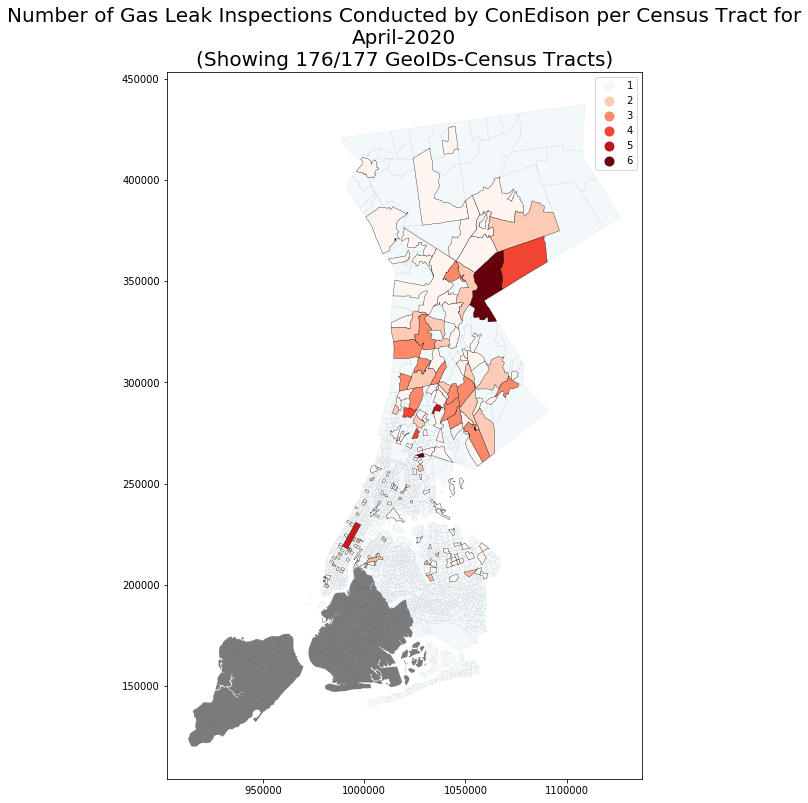

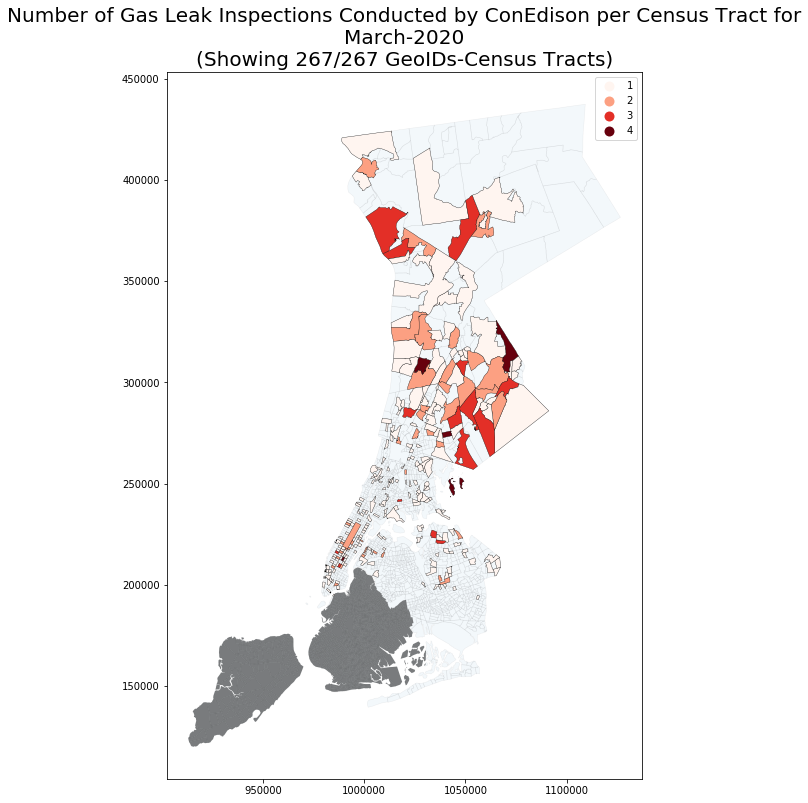

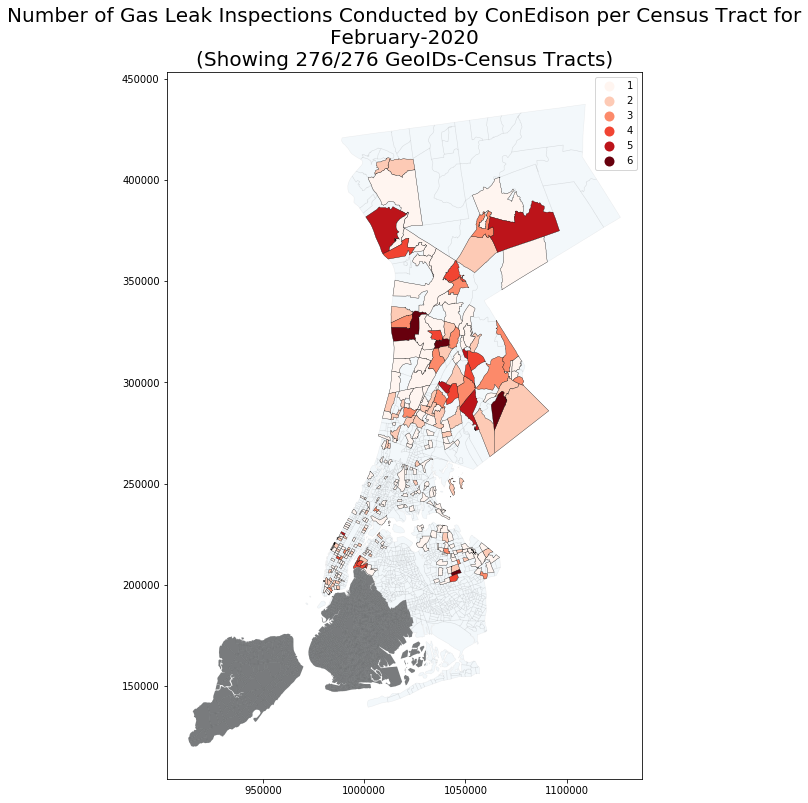

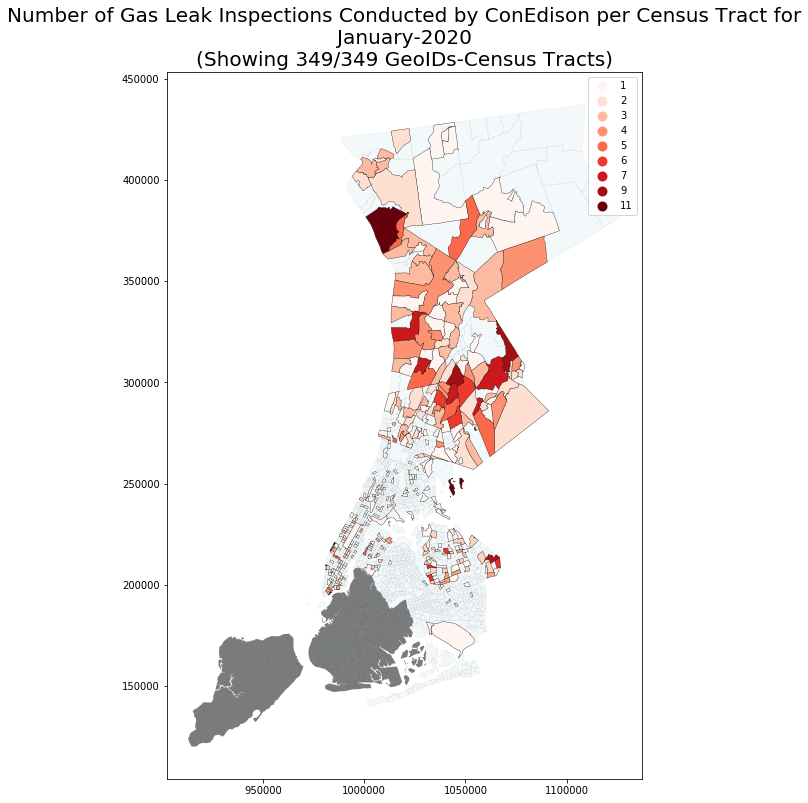

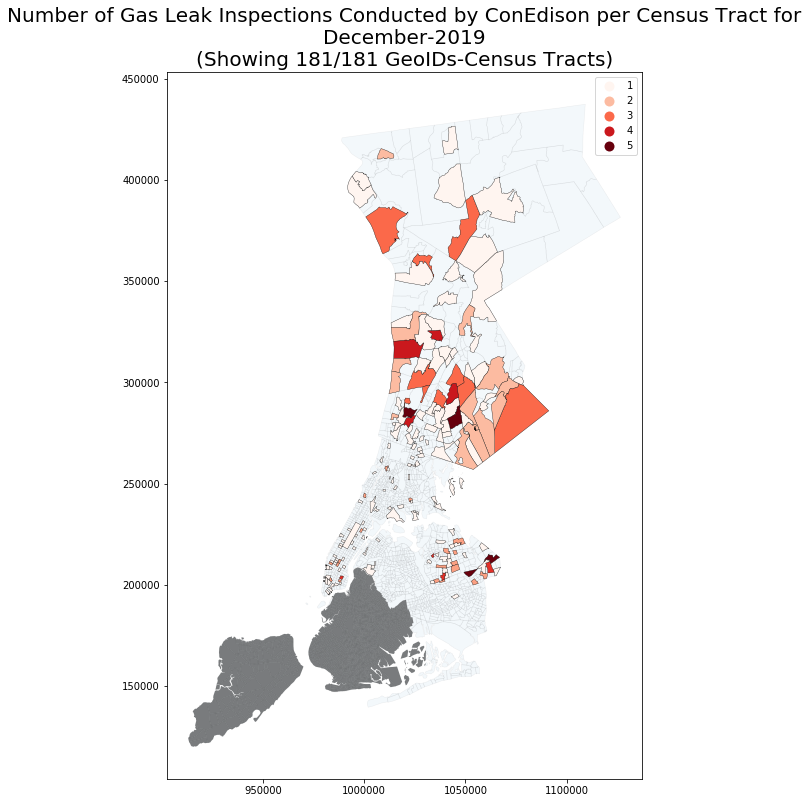

In [1]:
#%%     
# PLOTTING WITH GEOID, WESTCHESTER SHP NOT FOUND YET, NEED TO BLACK OUT BRROKLYN AND STATEN ISLAND
# Plotting the census tracts for all reports that appeared in a specific month                    
# import contextily as ctx
# import matploylib.pyplot as plt
import geopandas as gp
import os
import platform
import pandas as pd
import numpy as np

# A) CREATING DF AND GDF:
csvFile     = "DataFiles/ConEdison/GasHistory_2010_ReportFrequency_Monthly.csv"
outNYCFile  = "DataFiles/ConEdison/GasHistory_2010_ReportFrequency_Monthly_nycPlot.csv"
outWestFile = "DataFiles/ConEdison/GasHistory_2010_ReportFrequency_Monthly_westchesterPlot.csv"

nycFile         = "ShapeFiles/NYU_NYC_34505_SP/nyu_2451_34505.shp"
brooklynFile    = "ShapeFiles/TIGER_2010_County_Shapefiles/BrooklynCounty_2010SHP/tl_2010_36047_tract10.shp"
statenFile      = "ShapeFiles/TIGER_2010_County_Shapefiles/StatenIslanCounty_2010SHP"
westchesterFile = "ShapeFiles/westchester2010/wctigtrt10.shp"

monthlyDF = pd.read_csv(csvFile)                                                                            # Read the csv file and make a data frame
nycGDF = gp.read_file(nycFile)                                                                           # Read the shape file and make a data frame
brooklynGDF = gp.read_file(brooklynFile)
statenGDF = gp.read_file(statenFile)
westchesterGDF = gp.read_file(westchesterFile)

# CHANGE THE CRS SO THAT WESTCHESTER AND NYC ARE ON SAME MAP!
nycCRS = nycGDF.crs
westchesterGDF = westchesterGDF.to_crs(nycCRS)

DF_GEOID_COL  = "GEOID_SCT"
GDF_NYC_GEOID_COL = "tractid"
GDF_West_GEOID_COL = "GEOID10"
GDF_NYC_CENSUS_COL = "namelsad"
GDF_West_CENSUS_COL = "NAMELSAD10"
MIN_NUM_TRACTS_NEEDED_TO_PRINT = 140 #max westchester got in a month is 110

# B1) ADDING NEW COLS TO nycGDF westchesterGDF:    
# B2) CHNAGE DATATYPE OF COLS SO WE CAN COMPARE THEM:
mapArray       = [nycGDF,             westchesterGDF]
geoidColArray  = [GDF_NYC_GEOID_COL,  GDF_West_GEOID_COL]
censusColArray = [GDF_NYC_CENSUS_COL, GDF_West_CENSUS_COL]
for mapt in range(0,len(mapArray)):
    mapArray[mapt]["MonthYear"] = str                                                                                               # adding two new cols to nycGDF
    mapArray[mapt]["TotalMonthlyReport" ] = int
    mapArray[mapt]["CountyName"] = str 
    mapArray[mapt]["CensusBlockID_list"] = str  
    mapArray[mapt]["Ticket_list"] = str  
    mapArray[mapt]["Classification_list"] = str  
    mapArray[mapt]["Zipcode_list"] = str 
    mapArray[mapt]["CountyTract"] = str
    mapArray[mapt][[geoidColArray[mapt]]]   = mapArray[mapt][[geoidColArray[mapt]]].apply(pd.to_numeric).astype(int)                                      # Turning GDF_NYC_GEOID_COL - the CensusTract number to numpy.int64 values so can query them

# print("======================================================================================================== RAW DATA: GDF and monthly DF ========================================================================================================")
# print(nycGDF)
# print("------------------------------------------------------------------------ monthly DF:------------------------------------------")
# print(monthlyDF)
# print("=============================================================================================================== RAW DATA END =================================================================================================================")

# C) CON EDISON DOESNT INCLUDE DATA FROM STATEN ISLAND AND BROOKYLN SO GRAY THEM OUT
# BROOKLYN OUTLINE GDF:
print("\nMaking Brooklyn and Staten Island Outline Maps...")
bkGeoidList = list()
for row in range(0, len(brooklynGDF)):
    bkGeoidList.append(int(brooklynGDF.iloc[row]["GEOID10"]))
brooklynOutlineGDF = nycGDF.copy()
brooklynOutlineGDF.drop(brooklynOutlineGDF.index, inplace=True)  
skipGeoid = []
for geoid in range(0, len(bkGeoidList)):        
    bkGDF = nycGDF.loc[                                                                               # thisMonthsDF = df that contains all rows for that month-year
        (nycGDF[GDF_NYC_GEOID_COL]  == bkGeoidList[geoid]) 
    ]  
    if len(bkGDF)==0:
        print("******************* GEOID "+str(bkGeoidList[geoid])+" is in the Brooklyn County nycFile but is not in NYU NYC nycFile")
    skipGeoid.extend(bkGDF.index.tolist())
    bkGDF = bkGDF.reset_index(drop=True)
    brooklynOutlineGDF = brooklynOutlineGDF.append(bkGDF)
brooklynOutlineGDF.reset_index(drop=True)
# STATEN ISLAND OUTLINE GDF:
print("\nMaking Brooklyn and Staten Island Outline Maps...")
statenGeoidList = list()
for row in range(0, len(statenGDF)):
    statenGeoidList.append(int(statenGDF.iloc[row]["GEOID10"]))
statenOutlineGDF = nycGDF.copy()
statenOutlineGDF.drop(statenOutlineGDF.index, inplace=True)  
skipGeoid = []
for geoid in range(0, len(statenGeoidList)):        
    statenGDF = nycGDF.loc[                                                                               # thisMonthsDF = df that contains all rows for that month-year
        (nycGDF[GDF_NYC_GEOID_COL]  == statenGeoidList[geoid]) 
    ]  
    if len(statenGDF)==0:
        print("******************* GEOID "+str(statenGeoidList[geoid])+" is in the Staten Island COunty nycFile but is not in NYU NYC nycFile")
    skipGeoid.extend(statenGDF.index.tolist())
    statenGDF = statenGDF.reset_index(drop=True)
    statenOutlineGDF = statenOutlineGDF.append(statenGDF)
statenOutlineGDF.reset_index(drop=True)

# D) POPULATE THE NEWLY CREATED COLS:
print("\nPopulating new created columns and ploting monthly maps..")
skipMonthIndex = []
count = 0
thisMonthPlot_nycGDF  = nycGDF.copy()
thisMonthPlot_westGDF = westchesterGDF.copy() 
# 0) GO THROUGH EACH ROW OF THE MONTHLY CSV DATA AND PULL OUT ALL ROWS THAT ARE IN THE SAME MONTH -> FROM EACH MINI MONTH SEPERATED DF, SEPERATE FUTHER BY COUNTY NAME -> USE THE GEOID OF EACH COUNTY TO NAME THE GDF FILE
for row in range(0,len(monthlyDF)):
    thisMonthPlot_nycGDF.drop(thisMonthPlot_nycGDF.index, inplace=True)                           # resetting the month df for this new month
    thisMonthPlot_westGDF.drop(thisMonthPlot_westGDF.index, inplace=True) 
    if row in skipMonthIndex:
        continue

    # 1) SAME MONTH SEPERATION:
    thisMonthsDF = monthlyDF.loc[                                                                               # thisMonthsDF = df that contains all rows for that month-year
        (monthlyDF['MonthYear']  == monthlyDF['MonthYear'][row]) 
    ]  
    if len(thisMonthsDF) <= MIN_NUM_TRACTS_NEEDED_TO_PRINT:                                                                                  # If these r no reports for this month-year so skip
        continue
    skipMonthIndex.extend(thisMonthsDF.index.tolist())
    thisMonthsDF = thisMonthsDF.reset_index(drop=True)
    thisMonthGeoList = thisMonthsDF.GEOID_SCT.tolist()                                                          # need to put census tracts into an array, if i use directly from thisMonthsDF i get errors when there is no 
    thisMonthYrStr = monthlyDF['MonthYear'][row]

    # 1.2) CHECKING NUMBER FOR NYC AND WESTCHESTER COUNTY FROM CONED DATA 
    westCount = 0
    west = []
    nycCount = 0
    nyc = []
    for i in range(0,len(thisMonthsDF)):
        if thisMonthsDF.iloc[i]["CountyName_2010"]=="Westchester County":
            westCount = westCount+1
            west.append(thisMonthsDF.iloc[i][DF_GEOID_COL])
        else:
            nycCount = nycCount + 1
            nyc.append(thisMonthsDF.iloc[i][DF_GEOID_COL])
    print("--------------------------"+thisMonthYrStr)
    print("coned data - nyc  count: "+str(nycCount) + "          array len: "+str(len(nyc)))
    print("coned data - west count: "+str(westCount)+ "          array len: "+str(len(west)))
    print("coned data - total:  "+str(nycCount+westCount)+"/"+str(len(thisMonthsDF)))
    
    # 2) FOR CURRENT MONTH -> SEPERATE BY COUNTIES:
    skipCountyIndex = []
    for row2 in range(0,len(thisMonthsDF)):
        if row2 in skipCountyIndex:
            continue
        thisMonthsCountyDF = thisMonthsDF.loc[                                                                               # thisMonthsCountyDF = df that contains all rows for that month-year
            (thisMonthsDF['CountyName_2010']  == thisMonthsDF['CountyName_2010'][row2]) 
        ]      
        if len(thisMonthsCountyDF) == 0:                                                                                  # If these r no reports for this month-year so skip
            print("----------------- NO GEOID FOR THIS COUNTY: "+thisMonthsDF['CountyName_2010'][row2]+" FOR "+thisMonthYrStr)
            continue
        skipCountyIndex.extend(thisMonthsCountyDF.index.tolist())
        thisMonthsCountyDF = thisMonthsCountyDF.reset_index(drop=True)
        thisCountyStr = thisMonthsDF.iloc[row2]["CountyName_2010"]
        
        # 2.2) I HAVE TWO SHAPEFILES (NYC, Westchester). My data has all the counties. Using target index, mapArray[] and geoidColArray[] to choose the shapefile i want
        target = 0
        if thisCountyStr == "Westchester County":
            target = 1
        
        # 3) FOR THE COUNTY -> FIND THE GEOIDS FROM THE SHP AND POPULATE THE COLS
        rowCOunterc = -1
        for row3 in range(0,len(thisMonthsCountyDF)):
            thisMonthsCountyGeoGDF = mapArray[target].loc[                                                                               # thisMonthsCountyDF = df that contains all rows for that month-year
                (mapArray[target][geoidColArray[target]]  == thisMonthsCountyDF[DF_GEOID_COL][row3]) 
            ] 
            if len(thisMonthsCountyGeoGDF) == 0:                                                                                  # If these r no reports for this month-year so skip
                print("----------------- "+ thisMonthYrStr +":        NO GEOID THIS MONTH FOR COUNTY "+thisCountyStr)#+thisMonthsCountyGeoGDF[GDF_NYC_GEOID_COL][row3])
                continue
            thisMonthsCountyGeoGDF  = thisMonthsCountyGeoGDF.reset_index(drop=True)

            # 4) POPULATING THE COLS I ADDED FROM THE MONTHLY CSV DATA FOR THE SAME GEOIDS
            thisMonthsCountyGeoGDF.at[0, "MonthYear"] = thisMonthsCountyDF.loc[row3]["MonthYear"]
            thisMonthsCountyGeoGDF.at[0, "TotalMonthlyReport"] = thisMonthsCountyDF.loc[row3]["TotalReports"]
            thisMonthsCountyGeoGDF.at[0, "CountyName"] = thisMonthsCountyDF.loc[row3]["CountyName_2010"]
            thisMonthsCountyGeoGDF.at[0, "CensusBlockID_list"] = thisMonthsCountyDF.loc[row3]["CensusBlockID_list"]
            thisMonthsCountyGeoGDF.at[0, "Ticket_list"] = thisMonthsCountyDF.loc[row3]["Ticket_list"]
            thisMonthsCountyGeoGDF.at[0, "Classification_list"] = thisMonthsCountyDF.loc[row3]["Classification_list"]
            thisMonthsCountyGeoGDF.at[0, "Zipcode_list"] = thisMonthsCountyDF.loc[row3]["Zipcode_list"]  
            thisMonthsCountyGeoGDF.at[0, "CountyTract"] = thisMonthsCountyGeoGDF.iloc[0]["CountyName"]+"-"+str(thisMonthsCountyGeoGDF.iloc[0][censusColArray[target]]).split(" ")[2]   # Add "CountyName-TractNum" to the col
            if target == 0:
                thisMonthPlot_nycGDF  = thisMonthPlot_nycGDF.append(thisMonthsCountyGeoGDF)
            elif target == 1:
                thisMonthPlot_westGDF = thisMonthPlot_westGDF.append(thisMonthsCountyGeoGDF)
            else:
                print("ISSSSSSSSSSSSSSSUUUUUUUUUUUUUUUUUEEEEEEEEEEEEEEEEEEEEEEE!")
            # print("")
        thisMonthPlot_westGDF = thisMonthPlot_westGDF.reset_index(drop=True)
        thisMonthPlot_nycGDF = thisMonthPlot_nycGDF.reset_index(drop=True)
    print("plot nyc len: "+str(len(thisMonthPlot_nycGDF)))
    print("plot west len: "+str(len(thisMonthPlot_westGDF)))
    print('Plot total: '+str(len(thisMonthPlot_nycGDF)+ len(thisMonthPlot_westGDF))+"/"+str(len(thisMonthsDF)))

    # 5) PLOT THE MONTH'S DATA:
    figx = 14
    figy = 13
    ax = nycGDF.plot(alpha=0.05, edgecolor='black', linewidth = 0.6, figsize = (figx,figy))
    ax = brooklynOutlineGDF.plot(alpha=0.5, ax=ax, figsize = (figx,figy), color="black")
    ax = statenOutlineGDF.plot(alpha=0.5, ax=ax, figsize = (figx,figy), color="black")
    
    ax = thisMonthPlot_nycGDF.plot(column='TotalMonthlyReport',cmap = 'Reds', edgecolor='black', linewidth = 0.3, figsize = (figx,figy),legend = True, ax=ax)#, ax=ax, alpha=1) #10,8
    # map.set_title(label = 'Number of Gas Leak Reports per Census Tract for\n{0}\n(Showing {1}/{2} GeoIDs-Census Tracts)\n(Remaining Census Tracts are in Westcester County which isnt Plotted)'.format(thisMonthYrStr, len(thisMonthPlot_nycGDF), len(thisMonthsDF)), fontdict={'fontsize': 20}, loc='center')
    
    ax = westchesterGDF.plot(alpha=0.05, edgecolor='black', linewidth = 0.6, figsize = (figx,figy), ax=ax)
    map = thisMonthPlot_westGDF.plot(column='TotalMonthlyReport',cmap = 'Reds', edgecolor='black', linewidth = 0.3, figsize = (figx,figy),legend = True, ax=ax)#, ax=ax, alpha=1) #10,8
    map.set_title(label = 'Number of Gas Leak Inspections Conducted by ConEdison per Census Tract for\n{0}\n(Showing {1}/{2} GeoIDs-Census Tracts)'.format(thisMonthYrStr, (len(thisMonthPlot_westGDF)+len(thisMonthPlot_nycGDF)), len(thisMonthsDF)), fontdict={'fontsize': 20}, loc='center')

#%%